In [1]:
# Make environment
# Working directory
import sys, os
if os.path.exists('road_env'):
    sys.path.append('.')
else:
    sys.path.append('..')

# Register environment
from road_env import register_road_envs
register_road_envs()

# Make environment
import gymnasium as gym
env = gym.make('urban-road-v0', render_mode='rgb_array')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]
print('State dim:', state_dim, 'Action dim:', action_dim, 'Action range:', (-max_action, max_action))

State dim: 35 Action dim: 2 Action range: (-1.0, 1.0)


In [2]:
# Make DRL Agent
hidden_dim = 512

from rl_algorithms2.sac_v2 import SAC_Trainer, replay_buffer
agent = SAC_Trainer(
    state_dim=state_dim,
    action_dim=action_dim,
    action_range=max_action,
    hidden_dim=hidden_dim,
    replay_buffer=replay_buffer
)

cpu
Soft Q Network (1,2):  SoftQNetwork(
  (linear1): Linear(in_features=37, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=1, bias=True)
)
Policy Network:  PolicyNetwork(
  (linear1): Linear(in_features=35, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=512, bias=True)
  (mean_linear): Linear(in_features=512, out_features=2, bias=True)
  (log_std_linear): Linear(in_features=512, out_features=2, bias=True)
)


In [3]:
# Load trained model
model_type = 'sac_v2'
train_id = '230704203226'
episode = '10000'
model_dir = '../../data/models/' + model_type + '-' + train_id + '/' + episode
agent.load_model(model_dir)
print('Loaded from', model_dir)

Loaded from ../../data/models/sac_v2-230704203226/10000


In [4]:
from enum import Enum
import time
class OCCLUSION(Enum):
    Low = 1
    Medium = 2
    High = 3
    Random = 4

def run_test(env,
             occlusion_level,
             agent,
             num_episode=20,
             num_step=999,
             auto_randseed=True,
             render=False):
    if isinstance(occlusion_level, OCCLUSION):
        occlusion_level = occlusion_level._value_
    env.configure({
        'duration': num_step,
        'obstacle_preset': occlusion_level
    })
    infos = []
    start_time = time.time()
    for episode in range(num_episode):
        step = 0
        episode_reward = 0

        if auto_randseed:
            env.configure({
                'random_seed': int(episode * occlusion_level)
            })
        obs, info = env.reset()
        while True: # Number of steps controlled by env.config['duration]
            action = agent.policy_net.get_action(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            if render:
                env.render()

            d = {
                "episode": episode,
                "step": step,
                "reward": reward,
            }
            d.update(info)
            infos.append(d)

            step += 1
            episode_reward += reward
            if done or truncated:
                break
        print(f'Episode: {episode+1}, Steps: {step}')
    end_time = time.time()
    print(f'Total elapsed: {end_time-start_time: .3f}')
    return infos

In [5]:
from datetime import datetime
import os
import pandas as pd

test_id = datetime.now().strftime("%y%m%d%H%M%S")
infos = {}

for occ in OCCLUSION:
    print(occ)
    info = run_test(env, occ, agent)
    info = pd.DataFrame(info) # Convert into dataframe

    log_path = f"../../data/logs/test/{model_type}-{train_id}/{test_id}-{occ._value_}.csv"
    os.makedirs(os.path.dirname(log_path), exist_ok=True)
    info.to_csv(log_path, index=False)

    infos[occ] = info

OCCLUSION.Low


Episode: 1, Steps: 95
Episode: 2, Steps: 54
Episode: 3, Steps: 58
Episode: 4, Steps: 123
Episode: 5, Steps: 117
Episode: 6, Steps: 77
Episode: 7, Steps: 122
Episode: 8, Steps: 120
Episode: 9, Steps: 23
Episode: 10, Steps: 22
Episode: 11, Steps: 17
Episode: 12, Steps: 115
Episode: 13, Steps: 74
Episode: 14, Steps: 82
Episode: 15, Steps: 114
Episode: 16, Steps: 120
Episode: 17, Steps: 35
Episode: 18, Steps: 49
Episode: 19, Steps: 119
Episode: 20, Steps: 60
Total elapsed:  153.862
OCCLUSION.Medium
Episode: 1, Steps: 26
Episode: 2, Steps: 121
Episode: 3, Steps: 64
Episode: 4, Steps: 64
Episode: 5, Steps: 21
Episode: 6, Steps: 61
Episode: 7, Steps: 83
Episode: 8, Steps: 76
Episode: 9, Steps: 24
Episode: 10, Steps: 45
Episode: 11, Steps: 19
Episode: 12, Steps: 120
Episode: 13, Steps: 83
Episode: 14, Steps: 17
Episode: 15, Steps: 52
Episode: 16, Steps: 77
Episode: 17, Steps: 39
Episode: 18, Steps: 117
Episode: 19, Steps: 75
Episode: 20, Steps: 54
Total elapsed:  150.259
OCCLUSION.High
Episode

--- 
## Low Occlusion Level

In [6]:
df = infos[OCCLUSION.Low]
df.head()

,episode,step,reward,completed,collided,off_road,speed,heading,position_x,position_y,lane_id,observed_obstacles,observed_pedestrians,pedestrian_crossed
0,0,0,0.868730,False,False,False,2.366430,0.017302,6.103266,4.051921,1,1,0,0
1,0,1,0.736371,False,False,False,4.222760,0.051389,9.332898,4.244372,1,2,0,0
2,0,2,0.672896,False,False,False,4.684650,-0.081192,13.762119,3.866730,1,1,0,0
3,0,3,0.696229,False,False,False,5.332205,-0.044559,18.754181,3.638074,1,1,0,0
4,0,4,0.751725,False,False,False,5.422991,0.002964,24.131086,3.636537,1,1,1,0


<Axes: >

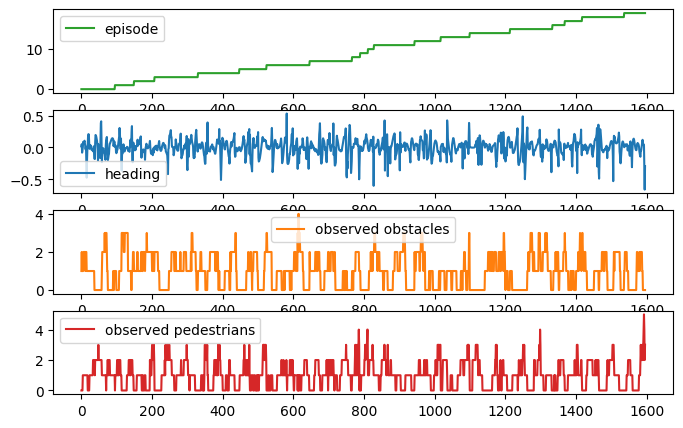

In [7]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=4, figsize=(8, 5))
df["episode"].plot(ax=axs[0], label='episode', legend=True, c='C2')
df["heading"].plot(ax=axs[1], label='heading', legend=True, c='C0')
df["observed_obstacles"].plot(ax=axs[2], label='observed obstacles', legend=True, c='C1')
df["observed_pedestrians"].plot(ax=axs[3], label='observed pedestrians', legend=True, c='C3')